In [2]:
# 1.Data exploration will give an overview of the data source and what an example looks like
from sklearn.datasets import fetch_20newsgroups

categories = ['rec.sport.baseball', 'rec.sport.hockey']
sports_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)
print(sports_dataset['data'][0])

From: dougb@comm.mot.com (Doug Bank)
Subject: Re: Info needed for Cleveland tickets
Reply-To: dougb@ecs.comm.mot.com
Organization: Motorola Land Mobile Products Sector
Distribution: usa
Nntp-Posting-Host: 145.1.146.35
Lines: 17

In article <1993Apr1.234031.4950@leland.Stanford.EDU>, bohnert@leland.Stanford.EDU (matthew bohnert) writes:

|> I'm going to be in Cleveland Thursday, April 15 to Sunday, April 18.
|> Does anybody know if the Tribe will be in town on those dates, and
|> if so, who're they playing and if tickets are available?

The tribe will be in town from April 16 to the 19th.
There are ALWAYS tickets available! (Though they are playing Toronto,
and many Toronto fans make the trip to Cleveland as it is easier to
get tickets in Cleveland than in Toronto.  Either way, I seriously
doubt they will sell out until the end of the season.)

-- 
Doug Bank                       Private Systems Division
dougb@ecs.comm.mot.com          Motorola Communications Sector
dougb@nwu.edu       

In [13]:
sports_dataset.target_names[sports_dataset['target'][0]]
len_all, len_baseball, len_hockey = len(sports_dataset.data), len([e for e in sports_dataset.target if e == 0]), len([e for e in sports_dataset.target if e == 1])

print(sports_dataset.target_names)
print(f"Total examples: {len_all}, Baseball examples: {len_baseball}, Hockey examples: {len_hockey}")

['rec.sport.baseball', 'rec.sport.hockey']
Total examples: 1197, Baseball examples: 597, Hockey examples: 600


In [18]:
# 2.Data preparation will turn our data source into a jsonl file that can be used for fine-tuning
import pandas as pd

labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
texts = [text.strip() for text in sports_dataset['data']]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
# print first 5 lines
df.head()
# generate jsonl file
df.to_json("sport2.jsonl", orient='records', lines=True)

In [19]:
# 3.Fine-tuning will kick off the fine-tuning job and explain the resulting model's performance
!pip install --upgrade openai
!openai tools fine_tunes.prepare_data -f sport2.jsonl -q

# automatically generate train and valid files


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Analyzing...

- Your file contains 1197 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 11 examples that are very long. These are rows: [134, 200, 281, 320, 404, 595, 704, 838, 1113, 1139, 1174]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-datase

In [25]:
# proceed fine-tuning with train and valid files
import os
import openai
from dotenv import load_dotenv

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [28]:
# blank before class name due to tokenization
!openai api fine_tunes.create -t "sport2_prepared_train.jsonl" -v "sport2_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " baseball" -m ada

Found potentially duplicated files with name 'sport2_prepared_train.jsonl', purpose 'fine-tune' and size 1519036 bytes
file-BFhOcLCYJ32WdiRunKZkBmJP
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: ^C



In [33]:
# when stream is disconnected, use the following command to follow the progress
# !openai api fine_tunes.follow -i ft-oedE7Gq0VoxLeZM9C2wQvBnq

[2023-05-20 23:53:27] Created fine-tune: ft-oedE7Gq0VoxLeZM9C2wQvBnq
[2023-05-20 23:56:29] Fine-tune costs $0.78
[2023-05-20 23:56:29] Fine-tune enqueued. Queue number: 0
[2023-05-21 00:06:34] Fine-tune started
[2023-05-21 00:09:20] Completed epoch 1/4
[2023-05-21 00:12:00] Completed epoch 2/4
[2023-05-21 00:14:40] Completed epoch 3/4
[2023-05-21 00:17:20] Completed epoch 4/4
[2023-05-21 00:17:55] Uploaded model: ada:ft-personal-2023-05-20-15-17-55
[2023-05-21 00:17:57] Uploaded result file: file-sKfUgAHyMuPrle6t3WJvRcEc
[2023-05-21 00:17:57] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-05-20-15-17-55 -p <YOUR_PROMPT>


In [ ]:
# Successfully result of fine-tuning

# [2023-05-20 23:53:27] Created fine-tune: ft-oedE7Gq0VoxLeZM9C2wQvBnq
# [2023-05-20 23:56:29] Fine-tune costs $0.78
# ...
# [2023-05-21 00:17:55] Uploaded model: ada:ft-personal-2023-05-20-15-17-55
# [2023-05-21 00:17:57] Uploaded result file: file-sKfUgAHyMuPrle6t3WJvRcEc
# [2023-05-21 00:17:57] Fine-tune succeeded
#
# Job complete! Status: succeeded 🎉
# Try out your fine-tuned model:
#
# openai api completions.create -m ada:ft-personal-2023-05-20-15-17-55 -p <YOUR_PROMPT>

In [35]:
# 3.5(Advanced). Download the results file to observe the expected performance on a held out validation set.
!openai api fine_tunes.results -i ft-oedE7Gq0VoxLeZM9C2wQvBnq > result.csv

<Axes: >

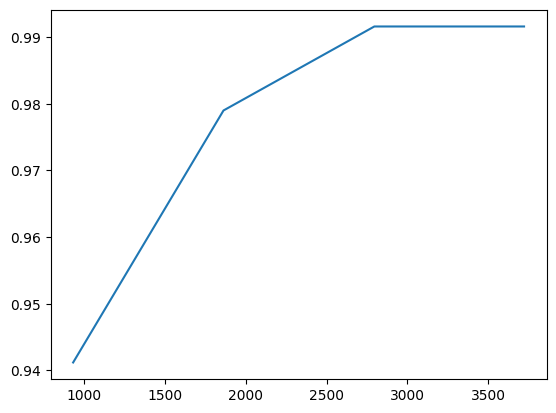

In [38]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

In [39]:
# 4.Using the model will demonstrate making requests to the fine-tuned model to get predictions.

test = pd.read_json('sport2_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
1,From: smorris@venus.lerc.nasa.gov (Ron Morris ...,hockey
2,From: golchowy@alchemy.chem.utoronto.ca (Geral...,hockey
3,From: krattige@hpcc01.corp.hp.com (Kim Krattig...,baseball
4,From: warped@cs.montana.edu (Doug Dolven)\nSub...,baseball


In [40]:
ft_model = 'ada:ft-personal-2023-05-20-15-17-55'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']

' hockey'

In [41]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x29b5f44d0> JSON: {
  " Hockey": -8.938456,
  " hockey": -0.00019404522
}

In [43]:
# 5. Generalization : Using the model on a different prompt. (Set 'Tweet' spec complete)

# example 1
sample_hockey_tweet = """Thank you to the
@Canes
 and all you amazing Caniacs that have been so supportive! You guys are some of the best fans in the NHL without a doubt! Really excited to start this new chapter in my career with the
@DetroitRedWings
 !!"""
res = openai.Completion.create(model=ft_model, prompt=sample_hockey_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

In [42]:
# example 2
sample_baseball_tweet="""BREAKING: The Tampa Bay Rays are finalizing a deal to acquire slugger Nelson Cruz from the Minnesota Twins, sources tell ESPN."""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' baseball'